<h1> Ship Type Prediction </h1>

<p align='justify'>

This Jupyter notebook contains a classification example which is
done with the help of Scikit-Learn library. In this notebook,
the following steps are performed:
</p>

<ol align='justify'>
    <li> The preprocessing i.e. feature generation, filtering and
         interpolation of the data is carried out using the
         PTRAIL Library.
    </li>
    <li> Further, several models like RandomForestClassifier, KMeans
         Classifier etc. are trained using the Scikit-Learn library
         based on the cleaned dataset.
    </li>
    <li>
        Finally, on the interpolated dataset, the type of ships are
        predicted and their accuracy is checked.
    </li>

In [1]:
# We are going to supress any UserWarnings for demonstration purposes.
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load the data into a pandas dataframe and convert it into a PTRAILDataFrame.
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

pdf = pd.read_csv('../data/ships.csv')
ships_df = PTRAILDataFrame(data_set=pdf.dropna(),
                           latitude='Lat',
                           longitude='Lon',
                           datetime='DateTime',
                           traj_id='VesselName')

# Filter out only Cargo, passenger and fishing ships.
ships = ships_df.loc[ships_df['VesselTypeGroup'].isin(['Cargo', 'Passenger', 'Fishing'])]

# Change the labels of the ShipTypes to the following:
# Cargo: 0
# Fishing: 1
# Passenger: 2
ships['VesselTypeGroup'] = ships['VesselTypeGroup'].map({'Cargo': 0, 'Fishing': 1,'Passenger': 2,})
ships = PTRAILDataFrame(data_set=ships.reset_index(),
                        latitude='lat',
                        longitude='lon',
                        datetime='Timestamp',
                        traj_id='Name')

ships.head()

MMSI        IMO       lat        lon  \
traj_id        DateTime                                                         
ADMIRAL   TIDE 2015-01-01 00:00:05  338433000  9184524.0  34.19727 -119.41710   
               2015-01-01 00:01:14  338433000  9184524.0  34.19817 -119.42057   
               2015-01-01 00:02:25  338433000  9184524.0  34.19911 -119.42421   
               2015-01-01 00:03:29  338433000  9184524.0  34.19997 -119.42749   
               2015-01-01 00:04:36  338433000  9184524.0  34.20086 -119.43086   

                                    SOG    COG  Heading CallSign  VesselType  \
traj_id        DateTime                                                        
ADMIRAL   TIDE 2015-01-01 00:00:05  9.6 -122.1    277.0  WDG7881          77   
               2015-01-01 00:01:14  9.6 -122.6    278.0  WDG7881          77   
               2015-01-01 00:02:25  9.6 -122.5    278.0  WDG7881          77   
               2015-01-01 00:03:29  9.6 -121.5    278.0  WDG7881          77   
               2015-01-01 00:04:36  9.7 -122.3    277.0  WDG7881          77   

                                    VesselTypeGroup  \
traj_id        DateTime                               
ADMIRAL   TIDE 2015-01-01 00:00:05                0   
               2015-01-01 00:01:14                0   
               2015-01-01 00:02:25                0   
               2015-01-01 00:03:29                0   
               2015-01-01 00:04:36                0   

                                             VesselTypeDescription  \
traj_id        DateTime                                              
ADMIRAL   TIDE 2015-01-01 00:00:05  Cargo, reserved for future use   
               2015-01-01 00:01:14  Cargo, reserved for future use   
               2015-01-01 00:02:25  Cargo, reserved for future use   
               2015-01-01 00:03:29  Cargo, reserved for future use   
               2015-01-01 00:04:36  Cargo, reserved for future use   

                                                    Status  Length  Width  \
traj_id        DateTime                                                     
ADMIRAL   TIDE 2015-01-01 00:00:05  under way using engine    62.0   14.0   
               2015-01-01 00:01:14  under way using engine    62.0   14.0   
               2015-01-01 00:02:25  under way using engine    62.0   14.0   
               2015-01-01 00:03:29  under way using engine    62.0   14.0   
               2015-01-01 00:04:36  under way using engine    62.0   14.0   

                                    Draft  Cargo  Zone Country Flag  
traj_id        DateTime                                              
ADMIRAL   TIDE 2015-01-01 00:00:05    4.5   77.0    11     USA   US  
               2015-01-01 00:01:14    4.5   77.0    11     USA   US  
               2015-01-01 00:02:25    4.5   77.0    11     USA   US  
               2015-01-01 00:03:29    4.5   77.0    11     USA   US  
               2015-01-01 00:04:36    4.5   77.0    11     USA   US

In [2]:
%%time

from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.filters import Filters
from ptrail.preprocessing.interpolation import Interpolation
from ptrail.preprocessing.statistics import Statistics

# Generate Kinematic Features first
feature_df = KinematicFeatures.generate_kinematic_features(dataframe=ships)

# Hampel Filter based on Distance and Speed.
dist_filter = Filters.hampel_outlier_detection(dataframe=feature_df, column_name='Distance')
speed_filter = Filters.hampel_outlier_detection(dataframe=dist_filter, column_name='Speed')

# Cubic Interpolation with a sampling rate of 15 minutes.
cubic_ip = Interpolation.interpolate_position(dataframe=speed_filter, sampling_rate=15,
                                              ip_type='cubic' ,class_label_col='VesselTypeGroup')

# Finally, generating Kinematic stats and pivoting the dataframe to get it ready for classification.
stats_df = Statistics.generate_kinematic_stats(dataframe=cubic_ip, target_col_name='VesselTypeGroup',segmented=False)
pivoted_df = Statistics.pivot_stats_df(dataframe=stats_df, target_col_name='VesselTypeGroup', segmented=False)
pivoted_df.dropna(inplace=True)

pivoted_df

CPU times: user 17.8 s, sys: 1.44 s, total: 19.2 s
Wall time: 1min 37s


,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,VesselTypeGroup
traj_id,,,,,,,,,,,,,,,,,,,,,
LYRA LEADER,108.745949,112.995689,121.364309,383.429860,400.324764,0.882526,3425.606263,253.201818,189.655457,20722.860230,...,-0.065578,-0.018986,-1.524647e-04,0.018091,0.068829,-3.863703,3.753725,-0.000954,0.183564,0
GRETA,0.357075,0.632900,1.230203,3.010590,4.614278,0.045499,12.562501,2.008064,1.875736,1.931818,...,-7.480144,-1.905707,-5.495042e-02,1.518414,7.730777,-23.100780,23.728706,0.004600,6.826181,0
ALASKAN COMMAND,0.552849,1.018626,2.014699,4.744031,7.416825,0.026180,17.285922,3.160925,2.895923,1.865332,...,-7.790852,-1.821167,-7.324242e-02,1.674919,8.802488,-22.915097,23.994274,0.064194,7.048065,1
YM EFFICIENCY,115.158731,119.986094,131.651261,409.198875,432.637919,0.208142,2407.309262,277.860397,206.440235,30071.355304,...,-0.026343,-0.006381,1.530504e-04,0.008275,0.032897,-14.913672,17.575143,0.003955,0.582241,0
HARVESTOR,0.224048,0.418203,0.893026,2.145281,4.178376,0.007222,683.503638,16.195157,67.495972,25433.825051,...,-6.569646,-1.518469,3.077968e-03,1.653434,7.031674,-23.688065,23.566738,0.096752,6.474556,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEALAND COMET,0.044523,0.681438,1.111981,10.945387,94.618746,0.044523,94.618746,20.844905,39.108614,0.000000,...,-1.104294,-0.000022,-2.781818e-07,0.000003,0.013568,-1.104295,0.035821,-0.240531,0.489845,0
CARNIVAL INSPIRATION,6.937034,10.674084,51.395823,612.645409,1253.191596,1.607094,2320.984557,453.797710,762.057432,89.319246,...,-0.473890,-0.018746,-1.350515e-03,0.028266,0.669600,-0.674330,3.102752,0.229348,1.106403,2
ROCKIES HIGHWAY,118.036213,122.956092,594.203459,65841.982181,180015.939577,112.196856,249707.498724,54892.558133,94277.891363,105215.836200,...,-0.011423,-0.000064,-1.573593e-05,0.000065,0.019840,-0.028392,0.049389,0.002998,0.023031,0


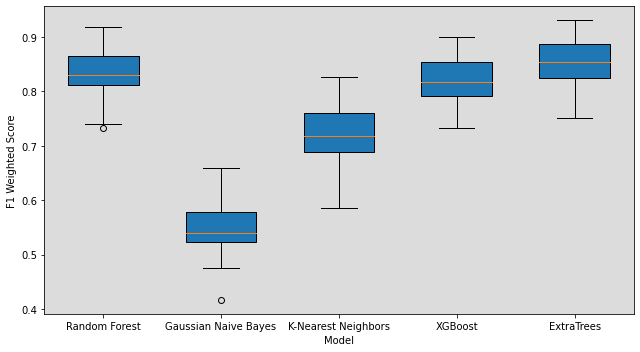

In [3]:
# Let's visualize the scores using box plot of cross validation of the models.
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

names = ["Random Forest", "Gaussian Naive Bayes", "K-Nearest Neighbors", "XGBoost", "ExtraTrees"]
models = [
    RandomForestClassifier(),
    GaussianNB(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier()
]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=10)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted_df.drop(columns=['VesselTypeGroup']), pivoted_df['VesselTypeGroup'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,
               widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F1 Weighted Score")
ax.set_xlabel("Model")
plt.tight_layout()